In [47]:
from io import open
import unicodedata
import string
import re
import random

In [48]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!wget https://download.pytorch.org/tutorial/data.zip

--2018-12-09 15:18:05--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 143.204.142.69, 143.204.142.88, 143.204.142.111, ...
Connecting to download.pytorch.org (download.pytorch.org)|143.204.142.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   

2018-12-09 15:18:05 (38.6 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [5]:
!unzip data.zip -d eng_fra

Archive:  data.zip
   creating: eng_fra/data/
  inflating: eng_fra/data/eng-fra.txt  
   creating: eng_fra/data/names/
  inflating: eng_fra/data/names/Arabic.txt  
  inflating: eng_fra/data/names/Chinese.txt  
  inflating: eng_fra/data/names/Czech.txt  
  inflating: eng_fra/data/names/Dutch.txt  
  inflating: eng_fra/data/names/English.txt  
  inflating: eng_fra/data/names/French.txt  
  inflating: eng_fra/data/names/German.txt  
  inflating: eng_fra/data/names/Greek.txt  
  inflating: eng_fra/data/names/Irish.txt  
  inflating: eng_fra/data/names/Italian.txt  
  inflating: eng_fra/data/names/Japanese.txt  
  inflating: eng_fra/data/names/Korean.txt  
  inflating: eng_fra/data/names/Polish.txt  
  inflating: eng_fra/data/names/Portuguese.txt  
  inflating: eng_fra/data/names/Russian.txt  
  inflating: eng_fra/data/names/Scottish.txt  
  inflating: eng_fra/data/names/Spanish.txt  
  inflating: eng_fra/data/names/Vietnamese.txt  


In [6]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
# Unicode string to ascii
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def readFile(file, reverse=False):

    lines = open(file, encoding='utf-8').read().strip().split('\n')

    # Split into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]

    return pairs

In [13]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [14]:
def prepareData(file, reverse=False):
    pairs = readFile(file, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    input_lang = Lang('french')
    output_lang = Lang('English')
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [15]:
input_lang, output_lang, pairs = prepareData('eng_fra/data/eng-fra.txt', True)
print(random.choice(pairs))

Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
french 4489
English 2925
['elles attendent toutes .', 'they re all waiting .']


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embeddings = self.embedding(input).view(1, 1, -1)
        embeddings_afterDropOut = self.dropout(embeddings)
        embeggings_N_hidden = torch.cat((embeddings_afterDropOut[0], hidden[0]), 1)
        
        attns = self.attn(embeggings_N_hidden)
        attn_weights = F.softmax(attns,dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embeddings_afterDropOut[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
teacher_forcing_ratio = 0.5
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [54]:
plt.switch_backend('agg')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [25]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [26]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [27]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder, attn_decoder, 1000, print_every=50)

0m 0s (- 0m 15s) (50 5%) 5.4716
0m 1s (- 0m 14s) (100 10%) 3.9732
0m 2s (- 0m 13s) (150 15%) 3.7305
0m 3s (- 0m 12s) (200 20%) 3.2805
0m 3s (- 0m 11s) (250 25%) 3.5100
0m 4s (- 0m 10s) (300 30%) 3.5416
0m 5s (- 0m 10s) (350 35%) 3.4972
0m 6s (- 0m 9s) (400 40%) 3.3588
0m 7s (- 0m 8s) (450 45%) 3.5230
0m 7s (- 0m 7s) (500 50%) 3.3450
0m 8s (- 0m 7s) (550 55%) 3.4426
0m 9s (- 0m 6s) (600 60%) 3.2351
0m 10s (- 0m 5s) (650 65%) 3.3165
0m 11s (- 0m 4s) (700 70%) 3.2423
0m 12s (- 0m 4s) (750 75%) 3.2791
0m 12s (- 0m 3s) (800 80%) 3.1603
0m 13s (- 0m 2s) (850 85%) 3.3636
0m 14s (- 0m 1s) (900 90%) 3.2888
0m 15s (- 0m 0s) (950 95%) 3.0773
0m 16s (- 0m 0s) (1000 100%) 3.1048


In [29]:
trainIters(encoder, attn_decoder, 65000, print_every=500)

0m 11s (- 25m 29s) (500 0%) 3.0573
0m 20s (- 21m 45s) (1000 1%) 2.8416
0m 29s (- 20m 50s) (1500 2%) 2.8226
0m 38s (- 20m 7s) (2000 3%) 2.7697
0m 46s (- 19m 33s) (2500 3%) 2.7386
0m 56s (- 19m 21s) (3000 4%) 2.6437
1m 4s (- 19m 2s) (3500 5%) 2.5636
1m 13s (- 18m 46s) (4000 6%) 2.4661
1m 22s (- 18m 29s) (4500 6%) 2.4940
1m 31s (- 18m 14s) (5000 7%) 2.4663
1m 40s (- 18m 3s) (5500 8%) 2.4397
1m 49s (- 17m 54s) (6000 9%) 2.3550
1m 58s (- 17m 47s) (6500 10%) 2.3177
2m 7s (- 17m 34s) (7000 10%) 2.3071
2m 16s (- 17m 27s) (7500 11%) 2.2616
2m 25s (- 17m 18s) (8000 12%) 2.2304
2m 34s (- 17m 7s) (8500 13%) 2.2175
2m 43s (- 16m 57s) (9000 13%) 2.1937
2m 52s (- 16m 45s) (9500 14%) 2.0883
3m 1s (- 16m 35s) (10000 15%) 2.1967
3m 10s (- 16m 26s) (10500 16%) 2.1267
3m 18s (- 16m 16s) (11000 16%) 2.0829
3m 28s (- 16m 7s) (11500 17%) 2.0170
3m 36s (- 15m 57s) (12000 18%) 1.9936
3m 45s (- 15m 47s) (12500 19%) 1.9308
3m 54s (- 15m 37s) (13000 20%) 1.8848
4m 3s (- 15m 27s) (13500 20%) 1.9383
4m 12s (- 15m 1

0m 5s (- 0m 12s) (300 30%) 0.7274
0m 10s (- 0m 7s) (600 60%) 0.6266
0m 16s (- 0m 1s) (900 90%) 0.6612


<Figure size 432x288 with 0 Axes>

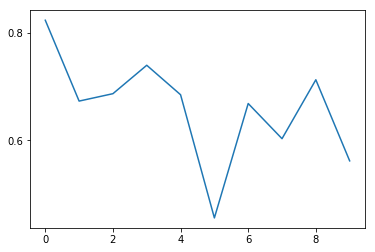

In [55]:
trainIters(encoder, attn_decoder, 1000, print_every=300)

In [56]:
evaluateRandomly(encoder, attn_decoder)

> vous etes imprudent .
= you re foolish .
< you re foolish . <EOS>

> il joue au golf .
= he is playing golf .
< he is playing playing . <EOS>

> tu es occupe en ce moment ?
= you are busy now aren t you ?
< you are busy now aren . <EOS>

> c est un maniaque du controle .
= he s a control freak .
< he s a control from . <EOS>

> nous ne sommes pas du coin .
= we re not from around here .
< we re not from around . <EOS>

> vous etes le meilleur .
= you re the greatest .
< you re the greatest . <EOS>

> nous sortons ensemble .
= we re dating .
< we re going back . <EOS>

> je suis un peu desoriente .
= i m a little confused .
< i m a little bit . <EOS>

> il n est pas du tout satisfait .
= he isn t happy at all .
< he is not satisfied at all . <EOS>

> elles sont nerveuses .
= they re jittery .
< they re jittery . <EOS>



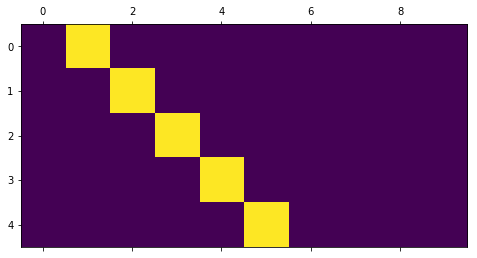

<Figure size 432x288 with 0 Axes>

In [57]:
output_words, attentions = evaluate(encoder, attn_decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())
plt.figure()
plt.show()

In [58]:
print(attentions.shape)
attentions

torch.Size([5, 10])


tensor([[ 6.6925e-05,  9.9917e-01,  6.0122e-04,  1.8251e-05,  1.7549e-07,
          8.4584e-05,  5.1501e-05,  1.5191e-08,  1.7068e-06,  4.6021e-06],
        [ 1.1898e-06,  1.6963e-06,  9.9829e-01,  6.6800e-05,  5.6517e-11,
          4.5454e-10,  3.8234e-09,  1.6158e-03,  2.6193e-05,  2.9606e-06],
        [ 1.2203e-07,  9.3102e-08,  2.9129e-06,  9.9925e-01,  7.3995e-04,
          2.6909e-11,  2.9902e-14,  3.8014e-08,  5.7700e-06,  7.1296e-07],
        [ 1.6093e-10,  6.3041e-10,  1.7564e-09,  8.4006e-10,  1.0000e+00,
          1.0141e-06,  3.9702e-10,  3.3980e-13,  9.3375e-12,  1.7953e-10],
        [ 1.8114e-05,  2.4354e-06,  1.6358e-06,  1.4422e-07,  2.0307e-08,
          9.9961e-01,  2.5396e-09,  3.2889e-07,  3.6132e-04,  5.1360e-06]])

input = elle a cinq ans de moins que moi .
output = she s five years younger than me am . <EOS>
input = elle est trop petit .
output = she s too short . <EOS>
input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a young young s young . <EOS>


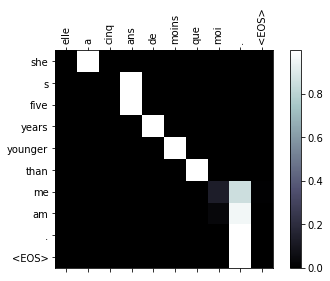

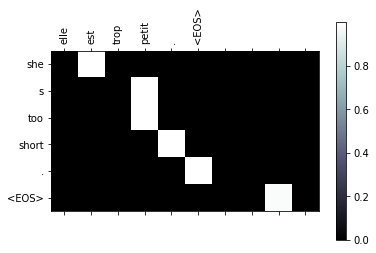

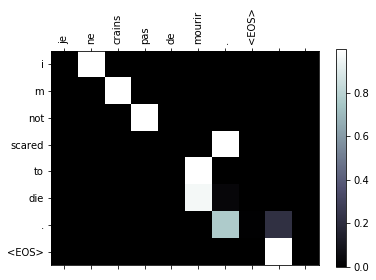

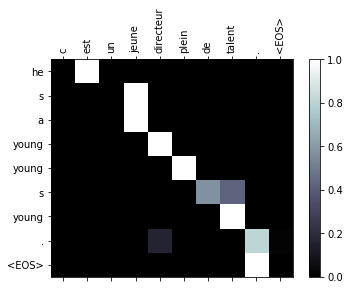

In [59]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")